In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import time
import pickle
from scipy import signal

In [2]:
'''data = pickle.load(open('../data/Data_test/*', "rb"), encoding='latin1')'''

'data = pickle.load(open(\'../data/Data_test/*\', "rb"), encoding=\'latin1\')'

In [3]:
save_figures = False
file_ending = '.png'
model_string = 'NMDA'

dataset_folder = '../data'

morphology_folder = os.path.join(dataset_folder, 'Morphology')
test_data_folder  = os.path.join(dataset_folder, 'Data_test')

morphology_filename      = os.path.join(morphology_folder, 'morphology_dict.pickle')
test_files               = sorted(glob.glob(os.path.join(test_data_folder, '*_128_simulationRuns*_6_secDuration_*')))

print('-----------------------------------------------')
print('finding files: morphology and test data')
print('-----------------------------------------------')
print('morphology found     : "%s"' %(morphology_filename.split('/')[-1]))
print('number of test files is %d' %(len(test_files)))
print('-----------------------------------------------')



-----------------------------------------------
finding files: morphology and test data
-----------------------------------------------
morphology found     : "morphology_dict.pickle"
number of test files is 12
-----------------------------------------------


In [5]:

#%% helper functions

def dict2bin(row_inds_spike_times_map, num_segments, sim_duration_ms): # 
    
    bin_spikes_matrix = np.zeros((num_segments, sim_duration_ms), dtype='bool') # creating a counter array
    for row_ind in row_inds_spike_times_map.keys():
        for spike_time in row_inds_spike_times_map[row_ind]:
            bin_spikes_matrix[row_ind,spike_time] = 1.0
    
    return bin_spikes_matrix #matrix counter

def parse_sim_experiment_file(sim_experiment_file):
    
    print('-----------------------------------------------------------------')
    print("loading file: '" + sim_experiment_file.split("\\")[-1] + "'")
    loading_start_time = time.time()
    experiment_dict = pickle.load(open(sim_experiment_file, "rb" ), encoding='latin1') # loading files
    
    # gather params
    num_simulations = len(experiment_dict['Results']['listOfSingleSimulationDicts'])
    num_segments    = len(experiment_dict['Params']['allSegmentsType'])
    sim_duration_ms = experiment_dict['Params']['totalSimDurationInSec']*1000
    num_ex_synapses  = num_segments
    num_inh_synapses = num_segments
    num_synapses = num_ex_synapses + num_inh_synapses ## WHY double the Synapse count????
    
    # collect X, y_spike, y_soma
    X = np.zeros((num_synapses,sim_duration_ms,num_simulations), dtype='bool')
    y_spike = np.zeros((sim_duration_ms,num_simulations))
    y_soma  = np.zeros((sim_duration_ms,num_simulations))
    for k, sim_dict in enumerate(experiment_dict['Results']['listOfSingleSimulationDicts']):
        X_ex  = dict2bin(sim_dict['exInputSpikeTimes'] , num_segments, sim_duration_ms)
        X_inh = dict2bin(sim_dict['inhInputSpikeTimes'], num_segments, sim_duration_ms)
        X[:,:,k] = np.vstack((X_ex,X_inh))
        spike_times = (sim_dict['outputSpikeTimes'].astype(float) - 0.5).astype(int)
        y_spike[spike_times,k] = 1.0
        y_soma[:,k] = sim_dict['somaVoltageLowRes']

    loading_duration_sec = time.time() - loading_start_time 
    print('loading took %.3f seconds' %(loading_duration_sec))
    print('-----------------------------------------------------------------')

    return X, y_spike, y_soma


def parse_multiple_sim_experiment_files(sim_experiment_files):
    
    for k, sim_experiment_file in enumerate(sim_experiment_files):
        X_curr, y_spike_curr, y_soma_curr = parse_sim_experiment_file(sim_experiment_file)
        
        if k == 0:
            X       = X_curr
            y_spike = y_spike_curr
            y_soma  = y_soma_curr
        else:
            X       = np.dstack((X,X_curr))
            y_spike = np.hstack((y_spike,y_spike_curr))
            y_soma  = np.hstack((y_soma,y_soma_curr))
            
    return X, y_spike, y_soma

In [6]:

#%% load test dataset

print('----------------------------------------------------------------------------------------')
print('loading testing files...')
test_file_loading_start_time = time.time()

v_threshold = -55

test_files = test_files[:3] # just load 3 files 

# load test data
X_test , y_spike_test , y_soma_test  = parse_multiple_sim_experiment_files(test_files)
y_soma_test[y_soma_test > v_threshold] = v_threshold

test_file_loading_duration_min = (time.time() - test_file_loading_start_time)/60
print('time took to load data is %.3f minutes' %(test_file_loading_duration_min))
print('----------------------------------------------------------------------------------------')



----------------------------------------------------------------------------------------
loading testing files...
-----------------------------------------------------------------
loading file: '../data/Data_test/sim__saved_InputSpikes_DVTs__561_outSpikes__128_simulationRuns__6_secDuration__randomSeed_100520.p'
loading took 55.788 seconds
-----------------------------------------------------------------
-----------------------------------------------------------------
loading file: '../data/Data_test/sim__saved_InputSpikes_DVTs__596_outSpikes__128_simulationRuns__6_secDuration__randomSeed_100511.p'
loading took 31.996 seconds
-----------------------------------------------------------------
-----------------------------------------------------------------
loading file: '../data/Data_test/sim__saved_InputSpikes_DVTs__632_outSpikes__128_simulationRuns__6_secDuration__randomSeed_100525.p'
loading took 35.429 seconds
-----------------------------------------------------------------
time to

In [14]:
y_soma_test


array([[-76.    , -76.    , -76.    , ..., -76.    , -76.    , -76.    ],
       [-76.375 , -76.375 , -76.375 , ..., -76.375 , -76.375 , -76.375 ],
       [-76.5625, -76.5625, -76.5   , ..., -76.5625, -76.6875, -76.25  ],
       ...,
       [-73.625 , -68.    , -73.875 , ..., -71.625 , -66.9375, -71.9375],
       [-73.8125, -67.8125, -73.9375, ..., -71.5   , -66.875 , -71.625 ],
       [-74.    , -67.6875, -74.    , ..., -71.3125, -67.    , -71.5625]])

In [8]:
##%% load morphology

morphology_dict = pickle.load(open(morphology_filename, "rb" ), encoding='latin1')

#lists of morphology

allSectionsLength                  = morphology_dict['all_sections_length']
allSections_DistFromSoma           = morphology_dict['all_sections_distance_from_soma']
allSegmentsLength                  = morphology_dict['all_segments_length']
allSegmentsType                    = morphology_dict['all_segments_type']
allSegments_DistFromSoma           = morphology_dict['all_segments_distance_from_soma']
allSegments_SectionDistFromSoma    = morphology_dict['all_segments_section_distance_from_soma']
allSegments_SectionInd             = morphology_dict['all_segments_section_index']
allSegments_seg_ind_within_sec_ind = morphology_dict['all_segments_segment_index_within_section_index']

all_basal_section_coords  = morphology_dict['all_basal_section_coords']
all_basal_segment_coords  = morphology_dict['all_basal_segment_coords']
all_apical_section_coords = morphology_dict['all_apical_section_coords']
all_apical_segment_coords = morphology_dict['all_apical_segment_coords']

seg_ind_to_xyz_coords_map = {}
seg_ind_to_sec_ind_map = {}
for k in range(len(allSegmentsType)):
    curr_segment_ind = allSegments_seg_ind_within_sec_ind[k]
    if allSegmentsType[k] == 'basal':
        curr_section_ind = allSegments_SectionInd[k]
        seg_ind_to_xyz_coords_map[k] = all_basal_segment_coords[(curr_section_ind,curr_segment_ind)]
        seg_ind_to_sec_ind_map[k] = ('basal', curr_section_ind)
    elif allSegmentsType[k] == 'apical':
        curr_section_ind = allSegments_SectionInd[k] - len(all_basal_section_coords)
        seg_ind_to_xyz_coords_map[k] = all_apical_segment_coords[(curr_section_ind,curr_segment_ind)]
        seg_ind_to_sec_ind_map[k] = ('apical', curr_section_ind)
    else:
        print('error!')


FileNotFoundError: [Errno 2] No such file or directory: 'data/Morphology/morphology_dict.pickle'

In [9]:
basal = len([i for i in morphology_dict['all_segments_type'] if i == 'basal']) # 262
apical = len([i for i in morphology_dict['all_segments_type'] if i == 'apical']) #377
apical

NameError: name 'morphology_dict' is not defined

In [40]:
len(all_basal_segment_coords) + len(all_basal_section_coords) #346


346

In [44]:


##%% load dendritic voltage traces of single simulation file

sim_experiment_file = test_files[0]
experiment_dict = pickle.load(open(sim_experiment_file, "rb" ), encoding='latin1')

X_spikes, _, _ = parse_sim_experiment_file(sim_experiment_file)

# gather params
num_simulations = len(experiment_dict['Results']['listOfSingleSimulationDicts'])
num_segments    = len(experiment_dict['Params']['allSegmentsType'])
sim_duration_ms = experiment_dict['Params']['totalSimDurationInSec']*1000

# collect X, y_spike, y_soma
sim_dict = experiment_dict['Results']['listOfSingleSimulationDicts'][0]

t_LR = sim_dict['recordingTimeLowRes']
t_HR = sim_dict['recordingTimeHighRes']
y_soma_LR  = np.zeros((sim_duration_ms,num_simulations))
y_nexus_LR = np.zeros((sim_duration_ms,num_simulations))
y_soma_HR  = np.zeros((sim_dict['somaVoltageHighRes'].shape[0],num_simulations))
y_nexus_HR = np.zeros((sim_dict['nexusVoltageHighRes'].shape[0],num_simulations))

y_DVTs  = np.zeros((num_segments,sim_duration_ms,num_simulations), dtype=np.float16)

# go over all simulations in the experiment and collect their results
for k, sim_dict in enumerate(experiment_dict['Results']['listOfSingleSimulationDicts']):
    y_nexus_LR[:,k] = sim_dict['nexusVoltageLowRes']
    y_soma_LR[:,k] = sim_dict['somaVoltageLowRes']    
    y_nexus_HR[:,k] = sim_dict['nexusVoltageHighRes']
    y_soma_HR[:,k] = sim_dict['somaVoltageHighRes']    
    y_DVTs[:,:,k] = sim_dict['dendriticVoltagesLowRes']

    output_spike_times = np.int32(sim_dict['outputSpikeTimes'])
    # put "voltage spikes" in low res
    y_soma_LR[output_spike_times,k] = 30



-----------------------------------------------------------------
loading file: 'data/Data_test/sim__saved_InputSpikes_DVTs__561_outSpikes__128_simulationRuns__6_secDuration__randomSeed_100520.p'
loading took 12.640 seconds
-----------------------------------------------------------------


In [47]:
experiment_dict['Results']['listOfSingleSimulationDicts']

random_simulation = 60


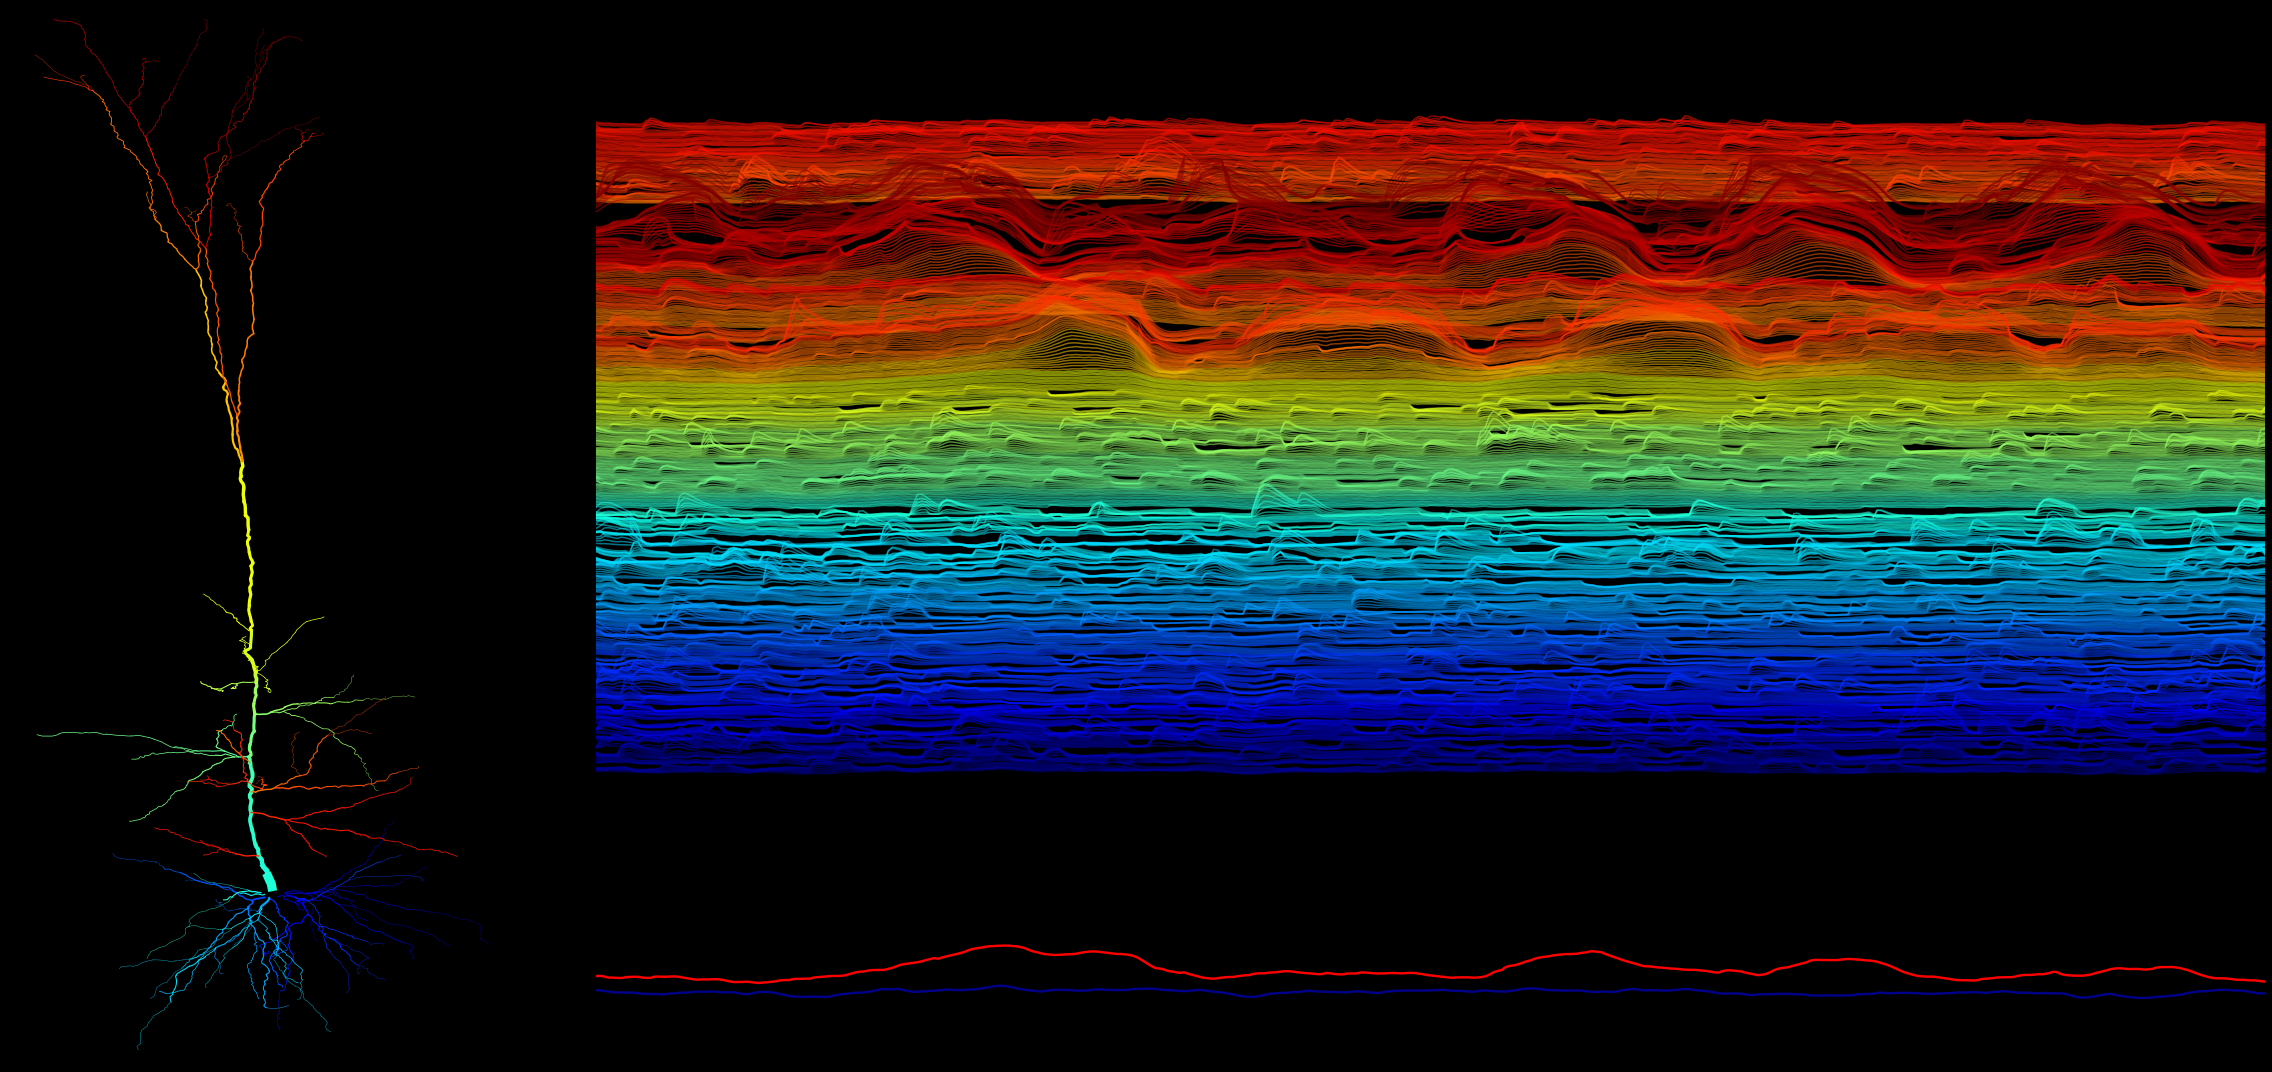

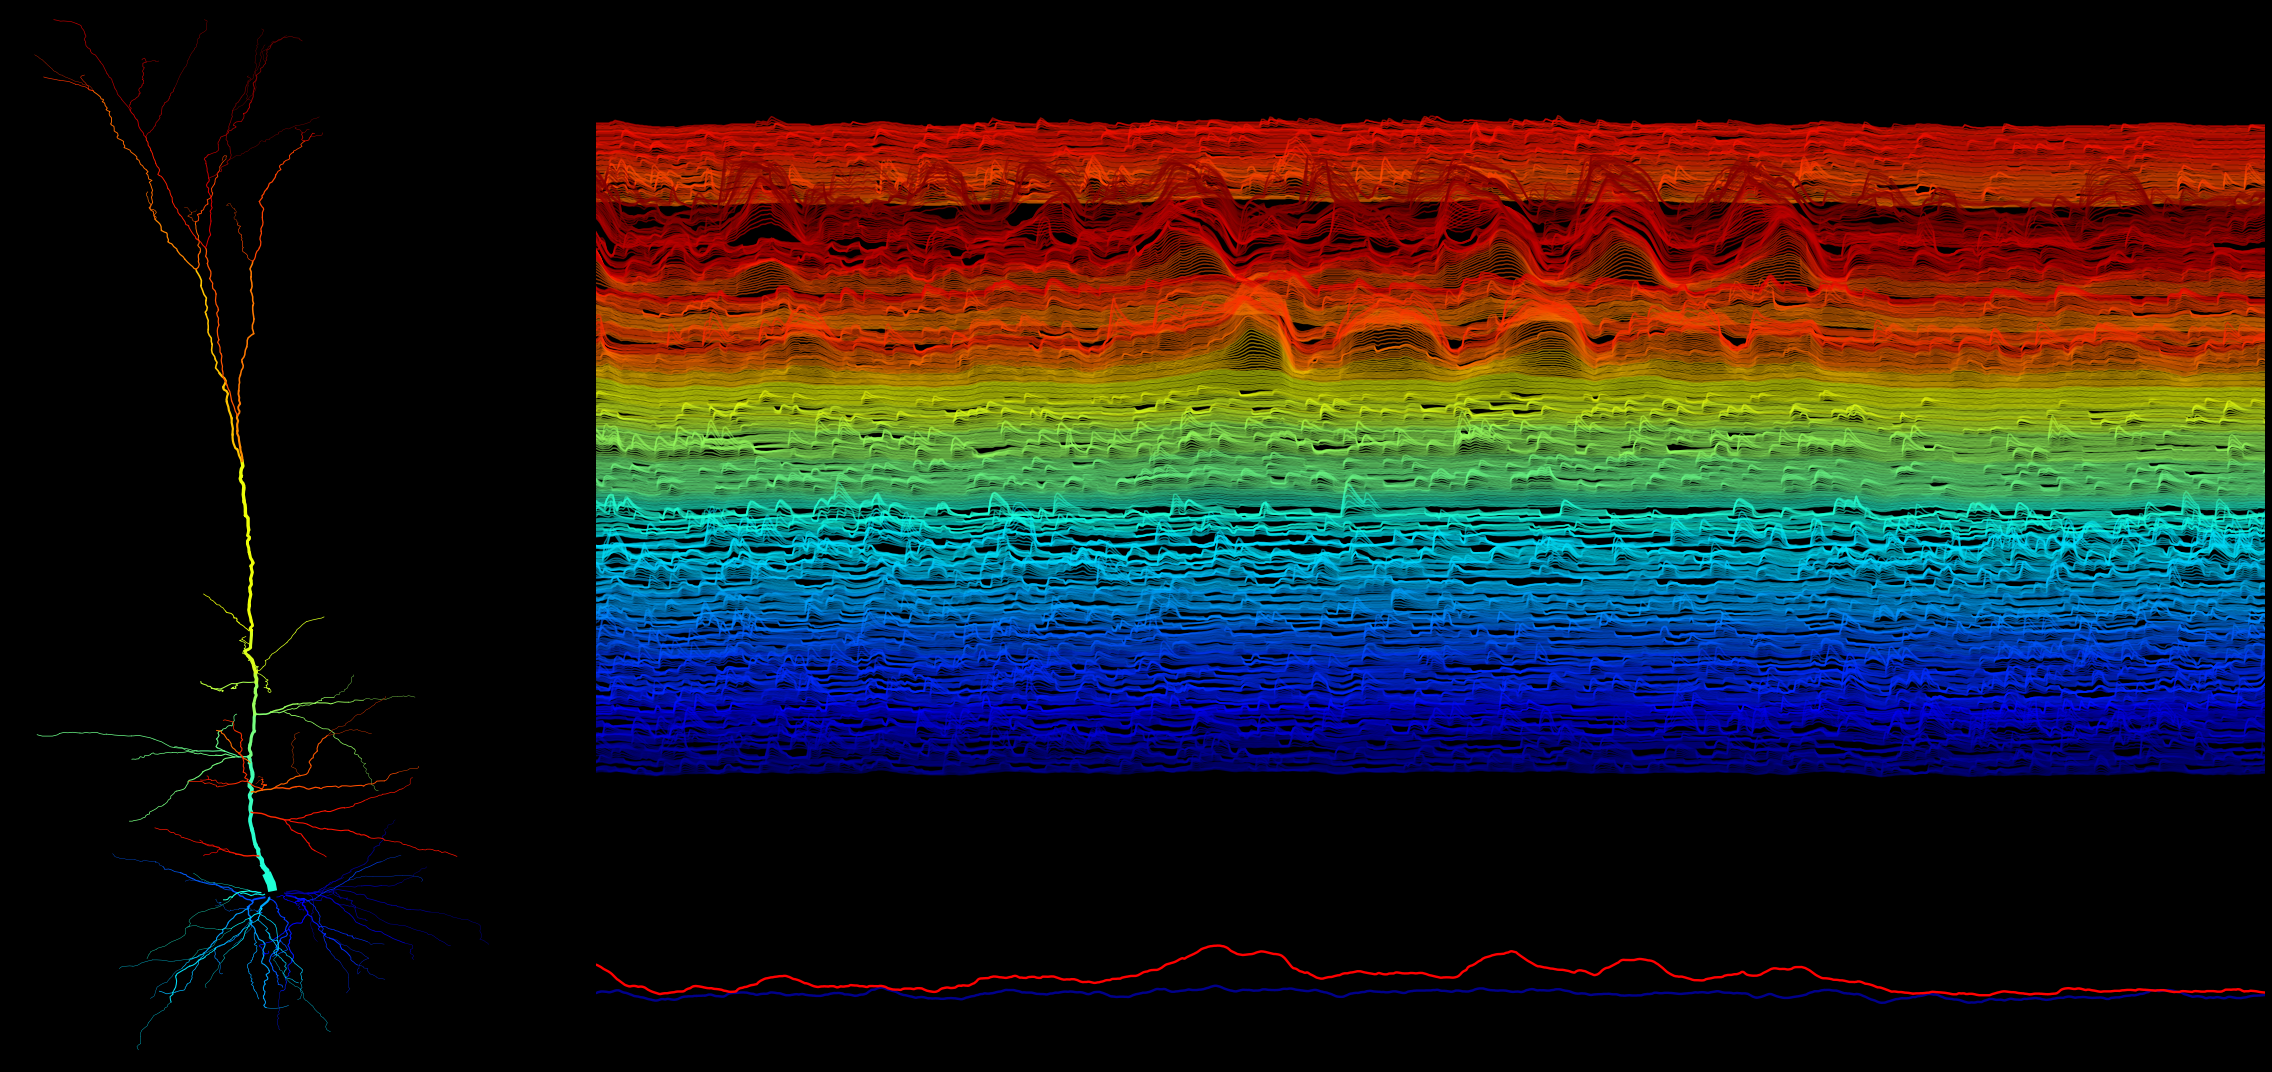

In [45]:


#%% show some colored DVTs with trace colors colorcoded with morphology segments
# also show soma and nexus voltage traces at the bottom

time_point_ranges_options = [[2800,3200],[2600,3400]]

# select random simulation to display
num_spikes_per_sim = (y_soma_LR > 20).sum(axis=0)
possible_simulations = np.nonzero(np.logical_and(num_spikes_per_sim >= 5, num_spikes_per_sim <= 30))[0]
random_simulation = np.random.choice(possible_simulations, size=1)[0]

print('random_simulation = %d' %(random_simulation))

for time_points_ranges in time_point_ranges_options:
    # choose time points to display
    # time_points_ranges = [2800,3200]
    width_mult_factor = 1.2

    duration_ms = time_points_ranges[1] - time_points_ranges[0]

    section_index      = np.array(experiment_dict['Params']['allSegments_SectionInd'])
    distance_from_soma = np.array(experiment_dict['Params']['allSegments_SectionDistFromSoma'])
    is_basal           = np.array([x == 'basal' for x in experiment_dict['Params']['allSegmentsType']])

    dend_colors = section_index*20 + distance_from_soma
    dend_colors = dend_colors / dend_colors.max()

    all_seg_inds = seg_ind_to_xyz_coords_map.keys()
    colors = plt.cm.jet(dend_colors)

    # assemble the colors for each dendritic segment
    colors_per_segment = {}
    for seg_ind in all_seg_inds:
        colors_per_segment[seg_ind] = colors[seg_ind]

    fig = plt.figure(figsize=(32,15))
    fig.subplots_adjust(left=0.01,right=0.99,top=0.99,bottom=0.01,hspace=0.01, wspace=0.2)

    ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=1)
    ax2 = plt.subplot2grid((1, 4), (0, 1), colspan=3)

    # plot the cell morphology
    ax1.set_axis_off()
    for key in all_seg_inds:
        seg_color = colors_per_segment[key]
        seg_line_width = width_mult_factor*np.array(seg_ind_to_xyz_coords_map[key]['d']).mean()
        seg_x_coords = seg_ind_to_xyz_coords_map[key]['x']
        seg_y_coords = seg_ind_to_xyz_coords_map[key]['y']

        ax1.plot(seg_x_coords,seg_y_coords,lw=seg_line_width,color=seg_color)

    # add black soma    
    ax1.scatter(x=45.5,y=19.8,s=120,c='k')
    ax1.set_xlim(-180,235)
    ax1.set_ylim(-210,1200)

    # plot the DVTs
    dend_colors = section_index*20 + distance_from_soma
    dend_colors = dend_colors / dend_colors.max()
    sorted_according_to_colors = np.argsort(dend_colors)
    delta_voltage = 700.0 / sorted_according_to_colors.shape[0]
    for k in sorted_according_to_colors:
        ax2.plot(t_LR, 150+k*delta_voltage+y_DVTs[k,:,random_simulation].T,c=colors[k], alpha=0.55)

    # plot the soma and nexus traces
    ax2.plot(t_HR[:], 2.3*y_soma_HR[:,random_simulation].T, c='darkblue', lw=2.4)
    ax2.plot(t_HR[:], 2.3*y_nexus_HR[:,random_simulation].T, c='red', lw=2.4)
    ax2.set_xlim(time_points_ranges[0],time_points_ranges[1]);
    ax2.set_axis_off()

    fig.patch.set_facecolor('black')
    #fig.patch.set_facecolor('0.12')
    
    if save_figures:
        figure_name = '%s__DVT_%d_ms_%d' %(model_string, duration_ms, np.random.randint(20))
        fig.savefig(output_figures_dir + figure_name + file_ending, bbox_inches='tight')



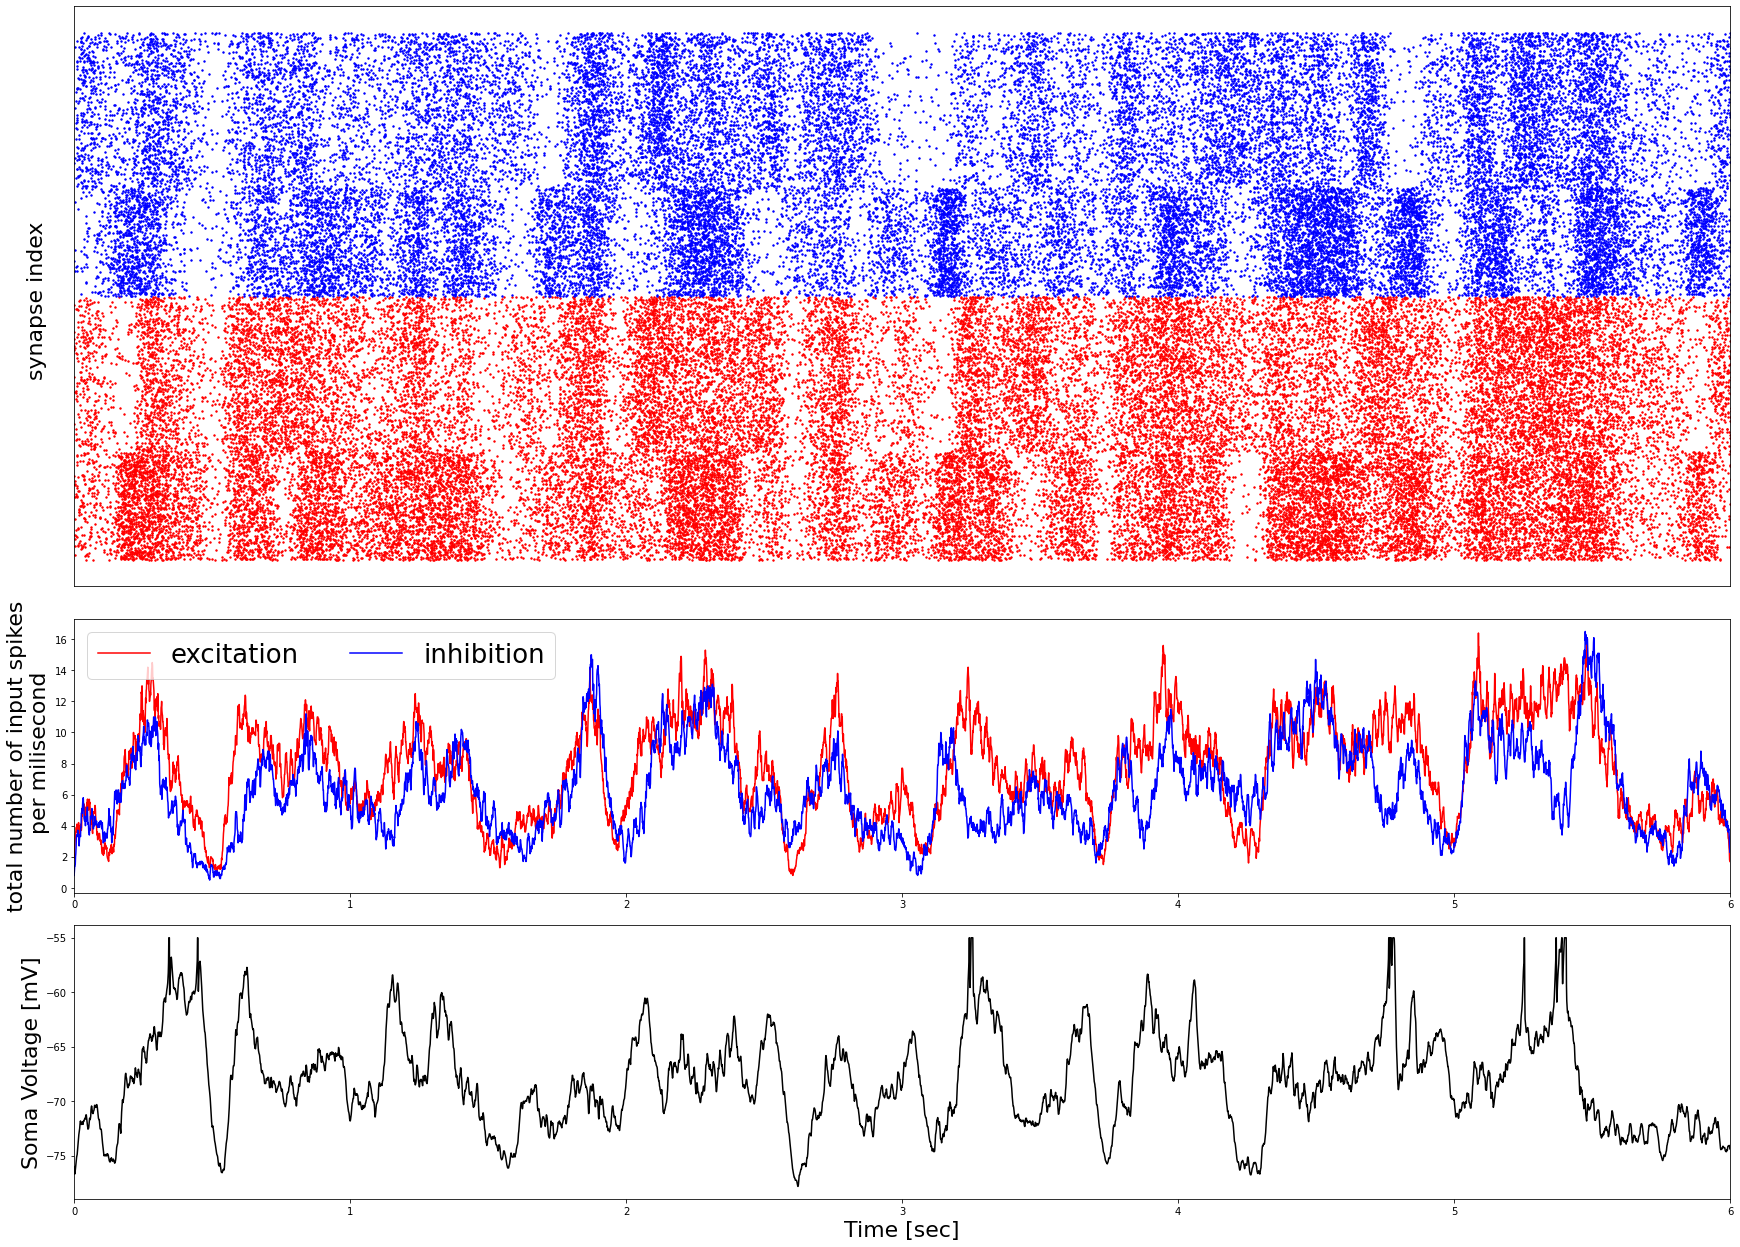

In [46]:
#%% show input spikes (X) and output somatic voltages

num_spikes_per_sim = y_spike_test.sum(axis=0)
possible_simulations = np.nonzero(np.logical_and(num_spikes_per_sim >= 3, num_spikes_per_sim <= 30))[0]
random_simulation = np.random.choice(possible_simulations, size=1)[0]

num_synapses = X_test.shape[0]
num_ex_synapses  = int(num_synapses/2)
num_inh_synapses = int(num_synapses/2)

# covert binary matrix to dict representation
all_presynaptic_spikes_bin = X_test[:,:,random_simulation]

exc_presynaptic_spikes = X_test[:num_ex_synapses,:,random_simulation].T
inh_presynaptic_spikes = X_test[num_ex_synapses:,:,random_simulation].T

#ex_presynaptic_spikes = X_test[random_simulation,:num_ex_synapses,:]
soma_voltage_trace = y_soma_test[:,random_simulation]
soma_voltage_trace[soma_voltage_trace > -30] = 30 # fix spikes height (that occurs due to low resolution temporal sampling)

# for raster plot (scatter)
exc_syn_activation_time, exc_syn_activation_index = np.nonzero(exc_presynaptic_spikes)
exc_syn_activation_time = exc_syn_activation_time / 1000.0

inh_syn_activation_time, inh_syn_activation_index = np.nonzero(inh_presynaptic_spikes)
inh_syn_activation_index = inh_syn_activation_index + num_ex_synapses
inh_syn_activation_time = inh_syn_activation_time / 1000.0


exc_instantaneous_firing_rate = exc_presynaptic_spikes.sum(axis=1)
inh_instantaneous_firing_rate = inh_presynaptic_spikes.sum(axis=1)

tau = 10
exc_instantaneous_firing_rate = signal.convolve(exc_instantaneous_firing_rate   , (1.0/tau)*np.ones((tau,)), mode='same')
inh_instantaneous_firing_rate = signal.convolve(inh_instantaneous_firing_rate   , (1.0/tau)*np.ones((tau,)), mode='same')

sim_duration_sec = sim_duration_ms / 1000.0
time_in_sec = np.arange(sim_duration_ms) / 1000.0


xytick_labels_fontsize = 16
title_fontsize = 30
xylabels_fontsize = 22
legend_fontsize = 26

fig = plt.figure(figsize=(25,18));
gs = gridspec.GridSpec(4,1)
gs.update(left=0.05, right=0.97, bottom=0.05, top=0.97, hspace=0.12)
ax0 = plt.subplot(gs[0:2,0])
ax1 = plt.subplot(gs[2,0])
ax2 = plt.subplot(gs[3,0])

ax0.scatter(exc_syn_activation_time, exc_syn_activation_index, s=2, c='r')
ax0.scatter(inh_syn_activation_time, inh_syn_activation_index, s=2, c='b')
#ax0.set_axis_off()
ax0.set_xlim(0,sim_duration_sec-0.01)
ax0.set_ylabel('synapse index \n', fontsize=xylabels_fontsize)
ax0.grid('off')
ax0.set_yticks([])
ax0.set_xticks([])

ax1.plot(time_in_sec, exc_instantaneous_firing_rate, c='r')
ax1.plot(time_in_sec, inh_instantaneous_firing_rate, c='b')
ax1.set_xlim(0,sim_duration_sec)
ax1.set_ylabel('total number of input spikes\n per milisecond', fontsize=xylabels_fontsize);
ax1.legend(['excitation', 'inhibition'], fontsize=legend_fontsize, loc='upper left', ncol=2);

ax2.plot(time_in_sec, soma_voltage_trace, c='k')
ax2.set_xlim(0,sim_duration_sec)
ax2.set_ylabel('Soma Voltage [mV]', fontsize=xylabels_fontsize);
ax2.set_xlabel('Time [sec]', fontsize=xylabels_fontsize);

if save_figures:
    figure_name = '%s__input_output_%d' %(model_string, np.random.randint(20))
    fig.savefig(output_figures_dir + figure_name + file_ending, bbox_inches='tight')